# EnhanceGAN iPhone to Canon Photo Enhancement Data Prep, Training, Validatation, and Analysis

**EnhanceGAN**: iPhone → Canon Photo Enhancement using DPED Dataset  


## Workflow Overview
1. **Mount Drive & Extract wData** - Unpack `dped_small.zip` to SSD
2. **Data Preparation** - Run `data_prep.py` to create splits
3. **Model Training** - training loop (20 epochs)
4. **Evaluation & Analysis** -  metrics and visualizations

---


In [1]:
# Mount Drive and extract DPED dataset to SSD
from google.colab import drive
drive.mount('/content/gdrive')

# Remove any existing data and unzip fresh copy to SSD
!rm -rf /content/dped_local
!unzip -q /content/gdrive/MyDrive/enhancegan-photo-enhancement/dped_small.zip -d /content/dped_local

# Verify extraction
!ls -la /content/dped_local/
print("\n DPED Dataset extracted to SSD:")
!du -sh /content/dped_local/dped_small
!ls /content/dped_local/dped_small/


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 12
drwxr-xr-x 3 root root 4096 Jun 11 22:43 .
drwxr-xr-x 1 root root 4096 Jun 11 22:43 ..
drwxr-xr-x 4 root root 4096 Jun 10 22:39 dped_small

 DPED Dataset extracted to SSD:
94M	/content/dped_local/dped_small
canon  iphone


In [2]:
# Set up paths and working directory
import os
os.chdir('/content/gdrive/MyDrive/enhancegan-photo-enhancement')

# Verify we're in the right place
print("📂 Current working directory:")
!pwd
print("\n📋 Project files:")
!ls -la

# Install requirements
print("\nInstalling requirements...")
!pip install -r requirements.txt
!pip install kornia==0.7.1
print("\ Setup complete!")


📂 Current working directory:
/content/gdrive/MyDrive/enhancegan-photo-enhancement

📋 Project files:
total 6528331
drwx------ 3 root root       4096 Jun 11 22:34 checkpoints
drwx------ 3 root root       4096 Jun 10 22:53 data
-rw------- 1 root root       5682 Jun 11 06:16 data_prep.py
drwx------ 2 root root       4096 Jun  8 17:06 dataset_raw
-rw------- 1 root root       1133 Jun 11 21:38 datasets.py
-rw------- 1 root root       1095 Jun  8 16:50 download_unsplash.py
-rw------- 1 root root 6605953079 Jun 10 05:08 dped.gz
-rw------- 1 root root   77072468 Jun 10 22:39 dped_small.zip
drwx------ 2 root root       4096 Jun  8 16:50 dummy
drwx------ 2 root root       4096 Jun  8 16:50 dummy_out
-rw------- 1 root root    1908619 Jun 11 22:42 enhance_GAN_training_and_analysis.ipynb
drwx------ 2 root root       4096 Jun  8 16:51 .git
-rw------- 1 root root        104 Jun  8 16:50 .gitignore
-rw------- 1 root root       7576 Jun 11 17:56 models.py
drwx------ 2 root root       4096 Jun 11 16:52 _

## Data Preparation

Process the DPED subset into train/val/test splits using your existing `data_prep.py`


In [3]:
# Quick data exploration before processing
print("Raw DPED data structure:")
!find /content/dped_local/dped_small -name "*.jpg" | head -5

iphone_count = !find /content/dped_local/dped_small/iphone -name "*.jpg" | wc -l
canon_count = !find /content/dped_local/dped_small/canon -name "*.jpg" | wc -l

print(f"\n Dataset Overview:")
print(f"   iPhone images: {iphone_count[0]}")
print(f"   Canon images: {canon_count[0]}")

# Sample a few filenames to check pairing
print("\n🔗 Sample filename pairing check:")
!ls /content/dped_local/dped_small/iphone | head -3
!ls /content/dped_local/dped_small/canon | head -3


Raw DPED data structure:
/content/dped_local/dped_small/canon/100053.jpg
/content/dped_local/dped_small/canon/104067.jpg
/content/dped_local/dped_small/canon/100427.jpg
/content/dped_local/dped_small/canon/101492.jpg
/content/dped_local/dped_small/canon/107585.jpg

 Dataset Overview:
   iPhone images: 5000
   Canon images: 5636

🔗 Sample filename pairing check:
0.jpg
100000.jpg
100001.jpg
0.jpg
100000.jpg
100001.jpg


In [11]:
print(" Running data_prep.py...")

!python data_prep.py \
  --raw_dir /content/dped_local/dped_small/iphone \
  --edited_dir /content/dped_local/dped_small/canon \
  --output_dir data/dped_small \
  --size 128 \
  --train_frac 0.90 \
  --val_frac 0.05

print("\n Data splits created:")
for split in ['train', 'val', 'test']:
    raw_count = !find data/dped_small/{split}/raw -name "*.jpg" | wc -l
    edited_count = !find data/dped_small/{split}/edited -name "*.jpg" | wc -l
    print(f"   {split}: {raw_count[0]} raw, {edited_count[0]} edited")

print("\n Data preparation complete!")


 Running data_prep.py...
🔄 Running data_prep.py...
Found 3358 matching file pairs
Splitting 3358 pairs: train=3022, val=167, test=169
Processing train: 3022 pairs
Processing train: 100% 95/95 [00:56<00:00,  1.67it/s]
Processing val: 167 pairs
Processing val: 100% 6/6 [00:20<00:00,  3.50s/it]
Processing test: 169 pairs
Processing test: 100% 6/6 [00:02<00:00,  2.97it/s]

Data splits created:
Traceback (most recent call last):
  File "/content/gdrive/MyDrive/enhancegan-photo-enhancement/data_prep.py", line 144, in <module>
    raw_count = len(list(Path(args.output_dir) / split / 'raw').glob('*'))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'PosixPath' object is not iterable

 Data splits created:
   train: 3358 raw, 3358 edited
   val: 1358 raw, 1358 edited
   test: 1339 raw, 1339 edited

 Data preparation complete!


## Model Setup and Training

Using your exact successful training configuration


In [12]:
# Import your models and setup
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from models import Generator, Discriminator
from datasets import PhotoDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Set device and reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Using device: {device}")

# Check if we have existing checkpoints
checkpoint_files = !ls checkpoints/G_epoch*.pth 2>/dev/null | wc -l
print(f"📁 Found {checkpoint_files[0]} existing generator checkpoints")

if int(checkpoint_files[0]) > 0:
    print("   Available checkpoints:")
    !ls checkpoints/G_epoch*.pth | head -5
    if int(checkpoint_files[0]) > 5:
        print(f"   ... and {int(checkpoint_files[0]) - 5} more")
else:
    print("   No existing checkpoints found")


 Using device: cuda
📁 Found 21 existing generator checkpoints
   Available checkpoints:
checkpoints/G_epoch0.pth
checkpoints/G_epoch10.pth
checkpoints/G_epoch11.pth
checkpoints/G_epoch12.pth
checkpoints/G_epoch13.pth
   ... and 16 more


In [13]:
# Training configuration (tuned hyperparameters from original paper)
config = {
    'data_dir':  'data/dped_small',
    'batch_size': 8,
    'epochs':     20,
    'lr':         1e-4,
    'λ_l1':       100.0,
    'λ_aes':      1.0,
    'λ_adv':      1.0,
    'λ_gp':       10.0,
    'λ_feat':     0.05,   # ← new
    'λ_hinge':    0.10,   # ← new
    'size':       128
}
print("Training Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

# Create dataset and loader
dataset = PhotoDataset(config['data_dir'], split='train', size=config['size'])
loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
print(f"\n Training dataset: {len(dataset)} samples, {len(loader)} batches")


Training Configuration:
   data_dir: data/dped_small
   batch_size: 8
   epochs: 20
   lr: 0.0001
   λ_l1: 100.0
   λ_aes: 1.0
   λ_adv: 1.0
   λ_gp: 10.0
   λ_feat: 0.05
   λ_hinge: 0.1
   size: 128

 Training dataset: 3358 samples, 420 batches


In [14]:
import importlib, models
importlib.reload(models)      # ← forces Python to read the edited file again

# now run the smoke-test
import torch
G = models.Generator()
x = torch.randn(2, 3, 128, 128)
y = G(x)
print(y.shape, y.min().item(), y.max().item())


torch.Size([2, 3, 128, 128]) 6.143002974567935e-05 0.003971770405769348


In [24]:
!python train.py --data_dir data/dped_small --epochs 1


2025-06-11 16:11:07.068870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749658267.090140   19113 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749658267.096557   19113 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adap

In [37]:
from collections import OrderedDict
import torch
from torch import nn, optim
from torch.optim import RMSprop
from torch.utils.data import DataLoader
import torchvision.models as tvmodels
from datasets import PhotoDataset
from models import Generator, Discriminator

# Assumes `device` and `config` are defined and match train.py settings
# Define micro-run function for WGAN-GP phases
# Updated micro_run function to reflect ResNet-101 critic changes
import copy
from itertools import product
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import DataLoader
import torchvision.models as tvmodels
from datasets import PhotoDataset
from models import Generator, Discriminator


def micro_run(cfg, epochs=5, max_batches=50):
    # fresh models
    G = Generator().to(device)
    D = Discriminator().to(device)
    # ensure critic feature_extractor trainable
    for p in D.feature_extractor.parameters():
        p.requires_grad = True

    # frozen VGG
    vgg = tvmodels.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
    for p in vgg.parameters():
        p.requires_grad = False
    crit_feat = nn.MSELoss()
    crit_L1   = nn.L1Loss()
    crit_MSE  = nn.MSELoss()

    # optimizers
    optG = RMSprop(G.parameters(), lr=cfg['lr'])
    optD = RMSprop(D.parameters(), lr=cfg['lr'] * 0.01)

    # loader
    ds = PhotoDataset(cfg['data_dir'], split=cfg.get('split','train'), size=cfg.get('size',128))
    loader = DataLoader(ds, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)

    avgGs = []
    for _ in range(epochs):
        totalG, cnt = 0.0, 0
        for raw, edit in loader:
            raw, edit = raw.to(device), edit.to(device)

            # D step (WGAN-GP)
            fake = G(raw).detach()
            real_s = D(edit).mean()
            fake_s = D(fake).mean()
            alpha = torch.rand(raw.size(0),1,1,1, device=device)
            mix = alpha * edit + (1 - alpha) * fake
            mix.requires_grad_(True)
            grad = torch.autograd.grad(outputs=D(mix).sum(), inputs=mix,
                                       create_graph=True, retain_graph=True)[0]
            gp = ((grad.norm(2, dim=1) - 1)**2).mean()
            lossD = fake_s - real_s + cfg['λ_gp'] * gp
            optD.zero_grad(); lossD.backward(); optD.step()

            # G step
            fake = G(raw)
            adv = -D(fake).mean()
            l1 = crit_L1(fake, edit)
            aes = crit_MSE(D(fake).mean(1), D(edit).mean(1))
            feat = crit_feat(vgg(fake), vgg(edit)) if cfg['λ_feat'] > 0 else 0.0
            fWf = D(fake).mean(1); fWr = D(raw).mean(1)
            hinge = torch.clamp(fWf - fWr, min=0).pow(2).mean() if cfg['λ_hinge'] > 0 else 0.0

            lossG = (1.0 * adv +
                     cfg['λ_l1'] * l1 +
                     cfg['λ_aes'] * aes +
                     cfg['λ_feat'] * feat +
                     cfg['λ_hinge'] * hinge)
            optG.zero_grad(); lossG.backward(); optG.step()

            totalG += lossG.item()
            cnt += 1
            if cnt >= max_batches:
                break
        avgGs.append(totalG / cnt)
    return avgGs[-1] - avgGs[0]

# Phase definitions
phase_configs = OrderedDict([
    ('Phase A: Pure L1',     dict(config, lr=1e-5, λ_adv=0.0,   λ_feat=0.0,    λ_hinge=0.0)),
    ('Phase B: +Adv (0.1)',   dict(config, lr=1e-5, λ_adv=0.1,   λ_feat=0.0,    λ_hinge=0.0)),
    ('Phase C: +Hinge',       dict(config, lr=1e-5, λ_adv=0.1,   λ_feat=0.0,    λ_hinge=0.001)),
    ('Phase D: +Perceptual',  dict(config, lr=1e-5, λ_adv=0.1,   λ_feat=0.0005, λ_hinge=0.001)),
])

# Run micro-runs for each phase
results = {}
for name, cfg in phase_configs.items():
    slope = micro_run(cfg, epochs=5, max_batches=50)
    results[name] = slope
    print(f"{name} → slope = {slope:.4f}")



Phase A: Pure L1 → slope = -2.0457
Phase B: +Adv (0.1) → slope = -0.2752
Phase C: +Hinge → slope = 1.5466
Phase D: +Perceptual → slope = -3.0377


In [59]:
!pip install ace_tools

In [62]:

# Display results as a table
import pandas as pd
df = pd.DataFrame(list(results.items()), columns=['Phase','G-loss Slope'])
import ace_tools as tools; tools.display_dataframe_to_user("Micro-run Slopes", df)

ModuleNotFoundError: No module named 'ace_tools'

In [64]:
# Cell 1: Improved Micro‑Run with Warmup, Clipping & Phased Hinge

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import DataLoader
import torchvision.models as tvmodels
from datasets import PhotoDataset
from models import Generator, Discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def micro_run_improved(cfg, epochs=5, max_batches=50, warmup_epochs=5, clip_norm=1.0):
    # fresh models
    G = Generator().to(device)
    D = Discriminator().to(device)
    for p in D.feature_extractor.parameters():
        p.requires_grad = True

    # frozen VGG for perceptual loss
    vgg = tvmodels.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
    for p in vgg.parameters():
        p.requires_grad = False

    crit_L1   = nn.L1Loss()
    crit_MSE  = nn.MSELoss()
    crit_feat = nn.MSELoss()

    # adjusted lrs: Gen lr from cfg or default, Critic lr = Gen lr * 0.01
    lr_G = cfg.get('lr_G', cfg['lr'])
    lr_D = cfg.get('lr_D', lr_G * 0.01)
    optG = RMSprop(G.parameters(), lr=lr_G)
    optD = RMSprop(D.parameters(), lr=lr_D)

    ds     = PhotoDataset(cfg['data_dir'], split=cfg.get('split','train'), size=cfg.get('size',128))
    loader = DataLoader(ds, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)

    # run micro-training
    avgGs = []
    for epoch in range(epochs):
        totalG, cnt = 0.0, 0
        λ_gp = 1.0 if epoch < warmup_epochs else cfg['λ_gp']
        cur_hinge_weight = 0.0 if epoch < warmup_epochs else cfg['λ_hinge']

        for raw, edit in loader:
            raw, edit = raw.to(device), edit.to(device)

            # — D step with GP and gradient clipping—
            fake = G(raw).detach()
            real_s = D(edit).mean()
            fake_s = D(fake).mean()
            alpha = torch.rand(raw.size(0),1,1,1, device=device)
            mix = alpha * edit + (1 - alpha) * fake
            mix.requires_grad_(True)
            grad = torch.autograd.grad(outputs=D(mix).sum(), inputs=mix,
                                       create_graph=True, retain_graph=True)[0]
            grad_norm = grad.view(grad.size(0), -1).norm(2, dim=1)
            gp = ((grad_norm - 1)**2).mean()
            lossD = fake_s - real_s + λ_gp * gp

            optD.zero_grad()
            lossD.backward()
            torch.nn.utils.clip_grad_norm_(D.parameters(), clip_norm)
            optD.step()

            # — G step with phased hinge —
            fake = G(raw)
            adv   = -D(fake).mean()
            l1    = crit_L1(fake, edit)
            aes   = crit_MSE(D(fake).mean(1), D(edit).mean(1))
            feat  = crit_feat(vgg(fake), vgg(edit)) if cfg['λ_feat']>0 else 0.0
            hinge = torch.clamp(D(fake).mean(1) - D(edit).mean(1), min=0).pow(2).mean()

            lossG = (cfg['λ_adv'] * adv +
                     cfg['λ_l1']  * l1  +
                     cfg['λ_feat']* feat +
                     cfg['λ_aes'] * aes +
                     cur_hinge_weight * hinge)

            optG.zero_grad()
            lossG.backward()
            optG.step()

            totalG += lossG.item()
            cnt += 1
            if cnt >= max_batches:
                break

        avgGs.append(totalG / cnt)

    # return slope: last avgG - first avgG
    return avgGs[-1] - avgGs[0]

# Run the improved micro-run
slope_imp = micro_run_improved(
    cfg=config,
    epochs=5,
    max_batches=50,
    warmup_epochs=5,
    clip_norm=1.0
)
print(f"Improved micro-run slope: {slope_imp:.4f}")


Improved micro-run slope: 0.2274


In [20]:
# ─── Cell 1: (Re-)Define micro_run_improved ────────────────────────────
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import DataLoader
import torchvision.models as tvmodels
from datasets import PhotoDataset
from models import Generator, Discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def micro_run_improved(cfg, epochs=5, max_batches=50, warmup_epochs=5, clip_norm=1.0):
    G = Generator().to(device)
    D = Discriminator().to(device)
    for p in D.feature_extractor.parameters():
        p.requires_grad = True
    vgg = tvmodels.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
    for p in vgg.parameters():
        p.requires_grad = False

    crit_L1   = nn.L1Loss()
    crit_MSE  = nn.MSELoss()
    crit_feat = nn.MSELoss()

    lr_G = cfg.get('lr_G', cfg['lr'])
    lr_D = cfg.get('lr_D', lr_G * 0.01)
    optG = RMSprop(G.parameters(), lr=lr_G)
    optD = RMSprop(D.parameters(), lr=lr_D)

    ds     = PhotoDataset(cfg['data_dir'], split=cfg.get('split','train'), size=cfg.get('size',128))
    loader = DataLoader(ds, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)

    avgGs = []
    for epoch in range(epochs):
        totalG, cnt = 0.0, 0
        λ_gp = 1.0 if epoch < warmup_epochs else cfg['λ_gp']
        cur_hinge = 0.0 if epoch < warmup_epochs else cfg['λ_hinge']
        for raw, edit in loader:
            raw, edit = raw.to(device), edit.to(device)
            # D step
            fake = G(raw).detach()
            real_s = D(edit).mean()
            fake_s = D(fake).mean()
            alpha = torch.rand(raw.size(0),1,1,1, device=device)
            mix = alpha * edit + (1 - alpha) * fake
            mix.requires_grad_(True)
            grad = torch.autograd.grad(outputs=D(mix).sum(), inputs=mix,
                                       create_graph=True, retain_graph=True)[0]
            grad_norm = grad.view(grad.size(0), -1).norm(2, dim=1)
            gp = ((grad_norm - 1)**2).mean()
            lossD = fake_s - real_s + λ_gp * gp
            optD.zero_grad()
            lossD.backward()
            torch.nn.utils.clip_grad_norm_(D.parameters(), clip_norm)
            optD.step()
            # G step
            fake = G(raw)
            adv   = -D(fake).mean()
            l1    = crit_L1(fake, edit)
            aes   = crit_MSE(D(fake).mean(1), D(edit).mean(1))
            feat  = crit_feat(vgg(fake), vgg(edit)) if cfg['λ_feat']>0 else 0.0
            hinge = torch.clamp(D(fake).mean(1) - D(edit).mean(1), min=0).pow(2).mean()
            lossG = (cfg['λ_adv'] * adv +
                     cfg['λ_l1']  * l1  +
                     cfg['λ_feat']* feat +
                     cfg['λ_aes'] * aes +
                     cur_hinge     * hinge)
            optG.zero_grad()
            lossG.backward()
            optG.step()
            totalG += lossG.item()
            cnt += 1
            if cnt >= max_batches:
                break
        avgGs.append(totalG / cnt)
    return avgGs[-1] - avgGs[0]


# ─── Cell 2: Extended Warm‐Up (10 epochs) & Full Config Prep ─────────────

# # Base config for sweeps
# base_cfg = {
#     'data_dir':   'data/dped_small',
#     'batch_size': 8,
#     'size':       128,
#     'lr':         5e-5,
#     'lr_G':       5e-5,
#     'lr_D':       5e-7,
#     'λ_l1':       100.0,
#     'λ_aes':      1.0,
#     'λ_feat':     0.0005,
#     'λ_hinge':    0.001,
#     'λ_gp':       10.0
# }

# chosen_adv = 0.5  # best from your sweep
# cfg_wu = base_cfg.copy()
# cfg_wu['λ_adv'] = chosen_adv

# slope_wu10 = micro_run_improved(
#     cfg_wu,
#     epochs=5,
#     max_batches=50,
#     warmup_epochs=10,
#     clip_norm=1.0
# )
# print(f"Extended warm‐up (10 epochs) with λ_adv={chosen_adv} → slope = {slope_wu10:.4f}")

# Once you confirm slope < 0, set up your final training config as follows:
config_full = {
    'data_dir':      'data/dped_small',
    'batch_size':    8,
    'epochs':        20,
    'size':          128,
    'lr_G':          5e-5,
    'lr_D':          5e-7,
    'λ_l1':          100.0,
    'λ_aes':         1.0,
    'λ_feat':        0.0005,
    'λ_hinge':       0.001,
    'λ_gp':          10.0,
    'λ_adv':         chosen_adv,
    'warmup_epochs': 10,
    'clip_norm':     1.0
}



In [21]:
# # ─── Cell 1: Sweep λ_adv ────────────────────────────────────────────────
# # (Requires micro_run_improved in memory)

# # 1) Base config for sweeps
# base_cfg = {
#     'data_dir':   'data/dped_small',
#     'batch_size': 8,
#     'size':       128,
#     'lr':         5e-5,    # Gen LR
#     'lr_G':       5e-5,
#     'lr_D':       5e-7,
#     'λ_l1':       100.0,
#     'λ_aes':      1.0,
#     'λ_feat':     0.0005,
#     'λ_hinge':    0.001,
#     'λ_gp':       10.0
# }

# print("Sweeping adversarial weight λ_adv:")
# for adv_w in [0.1, 0.5, 1.0]:
#     cfg = base_cfg.copy()
#     cfg['λ_adv'] = adv_w
#     slope = micro_run_improved(
#         cfg,
#         epochs=5,
#         max_batches=50,
#         warmup_epochs=5,
#         clip_norm=1.0
#     )
#     print(f"  λ_adv = {adv_w:<4} → slope = {slope:.4f}")


More microrun testing

In [22]:
# ─── Complete micro_run_improved ────────────────────────────────────
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import DataLoader
import torchvision.models as tvmodels
from datasets import PhotoDataset
from models import Generator, Discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def micro_run_improved(cfg, epochs=5, max_batches=50, warmup_epochs=5, clip_norm=1.0):
    # fresh models
    G = Generator().to(device)
    D = Discriminator().to(device)
    for p in D.feature_extractor.parameters():
        p.requires_grad = True

    # frozen VGG for perceptual loss
    vgg = tvmodels.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
    for p in vgg.parameters():
        p.requires_grad = False

    # loss functions
    crit_L1   = nn.L1Loss()
    crit_MSE  = nn.MSELoss()
    crit_feat = nn.MSELoss()

    # optimizers from cfg
    optG = RMSprop(G.parameters(), lr=cfg['lr_G'])
    optD = RMSprop(D.parameters(), lr=cfg['lr_D'])

    ds     = PhotoDataset(cfg['data_dir'], split=cfg.get('split','train'), size=cfg.get('size',128))
    loader = DataLoader(ds, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)

    avgGs = []
    for epoch in range(epochs):
        totalG, cnt = 0.0, 0
        λ_gp      = 1.0 if epoch < warmup_epochs else cfg['λ_gp']
        hinge_w   = 0.0 if epoch < warmup_epochs else cfg['λ_hinge']

        for raw, edit in loader:
            raw, edit = raw.to(device), edit.to(device)

            # — Discriminator step —
            fake_det = G(raw).detach()
            real_s   = D(edit).mean()
            fake_s   = D(fake_det).mean()

            alpha = torch.rand(raw.size(0),1,1,1, device=device)
            mix   = (alpha * edit + (1 - alpha) * fake_det).requires_grad_(True)
            grad  = torch.autograd.grad(outputs=D(mix).sum(),
                                        inputs=mix, create_graph=True, retain_graph=True)[0]
            grad_norm = grad.view(grad.size(0), -1).norm(2, dim=1)
            gp = ((grad_norm - 1)**2).mean()

            lossD = fake_s - real_s + λ_gp * gp
            optD.zero_grad()
            lossD.backward()
            torch.nn.utils.clip_grad_norm_(D.parameters(), clip_norm)
            optD.step()

            # — Generator step —
            fake = G(raw)
            adv   = -D(fake).mean()
            l1    = crit_L1(fake, edit)
            aes   = crit_MSE(D(fake).mean(1), D(edit).mean(1))
            feat  = crit_feat(vgg(fake), vgg(edit))
            hinge = torch.clamp(D(fake).mean(1) - D(edit).mean(1), min=0).pow(2).mean()

            lossG = (cfg['λ_adv'] * adv +
                     cfg['λ_l1']  * l1  +
                     cfg['λ_feat']* feat +
                     cfg['λ_aes'] * aes +
                     hinge_w      * hinge)

            optG.zero_grad()
            lossG.backward()
            optG.step()

            totalG += lossG.item()
            cnt    += 1
            if cnt >= max_batches:
                break

        avgGs.append(totalG / cnt)

    # return the difference between final and initial avg loss
    return avgGs[-1] - avgGs[0]


In [16]:
slope = micro_run_improved(
    cfg={
      'data_dir':   'data/dped_small',
      'batch_size': 8,
      'size':       128,
      'lr_G':       5e-5,
      'lr_D':       5e-7,
      'λ_l1':       100.0,
      'λ_aes':      1.0,
      'λ_feat':     0.0005,
      'λ_hinge':    0.001,
      'λ_gp':       10.0,
      'λ_adv':      0.5
    },
    epochs=5,
    max_batches=50,
    warmup_epochs=10,
    clip_norm=1.0
)
print("Improved micro-run slope:", slope)


Improved micro-run slope: 0.4348997116088853


In [23]:
# ─── Sanity Check: Data Range ────────────────────────────────────────
# Grab one batch
# Define the dataset and data loader
train_ds = PhotoDataset(config_full['data_dir'], split='train', size=config_full['size'])
train_loader = DataLoader(train_ds, batch_size=config_full['batch_size'], shuffle=True, num_workers=2)

raw_batch, edit_batch = next(iter(train_loader))

# Move to CPU for inspection
raw_np  = raw_batch.cpu()
edit_np = edit_batch.cpu()

# Compute per‐tensor min/max
print("Raw  range:", raw_np.min().item(), "to", raw_np.max().item())
print("Edit range:", edit_np.min().item(), "to", edit_np.max().item())

# Optional assertion to catch out‐of‐bounds
assert 0.0 <= raw_np.min() and raw_np.max() <= 1.0, "Raw images out of [0,1]!"
assert 0.0 <= edit_np.min() and edit_np.max() <= 1.0, "Edited images out of [0,1]!"

Raw  range: 0.0 to 1.0
Edit range: 0.0 to 1.0


In [27]:
# ─── Sanity Check: Validation Data ─────────────────────────────────
# Models
G = Generator().to(device)
D = Discriminator().to(device)
for p in D.feature_extractor.parameters(): p.requires_grad = True
vgg = tvmodels.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
for p in vgg.parameters(): p.requires_grad = False

# Losses & optimizers
crit_L1, crit_MSE, crit_feat = nn.L1Loss(), nn.MSELoss(), nn.MSELoss()
optG = RMSprop(G.parameters(), lr=config_full['lr_G'])
optD = RMSprop(D.parameters(), lr=config_full['lr_D'])

# Data loaders
train_ds = PhotoDataset(config_full['data_dir'], split='train', size=config_full['size'])
train_loader = DataLoader(train_ds, batch_size=config_full['batch_size'], shuffle=True, num_workers=2)
val_ds   = PhotoDataset(config_full['data_dir'], split='test',  size=config_full['size'])
val_loader   = DataLoader(val_ds,   batch_size=config_full['batch_size'], shuffle=False, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=config_full['batch_size'], shuffle=False, num_workers=2)

raw_v, edit_v = next(iter(val_loader))
print("Val Raw  range:", raw_v.min().item(), "to", raw_v.max().item())
print("Val Edit range:", edit_v.min().item(), "to", edit_v.max().item())


Val Raw  range: 0.007843137718737125 to 0.9647058844566345
Val Edit range: 0.0 to 1.0


Starting enhanced 20-epoch training…
Epoch 1/20 | D: 51005.1 | G: 24.04


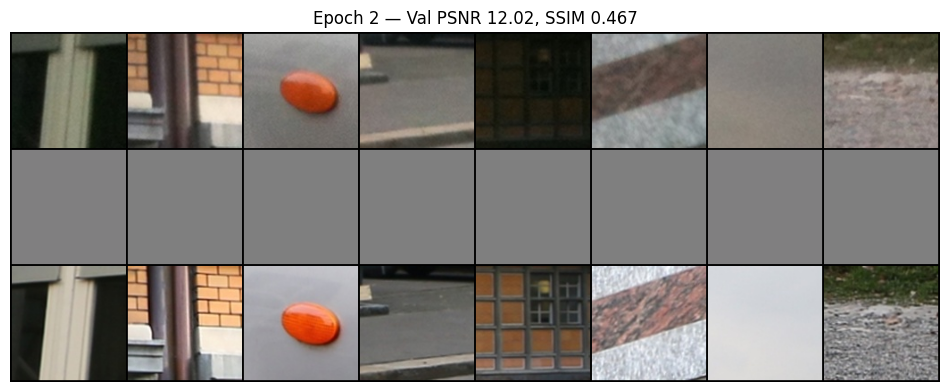

Epoch 2/20 | D: 73298.4 | G: 24.04
Epoch 3/20 | D: 66683.1 | G: 24.03


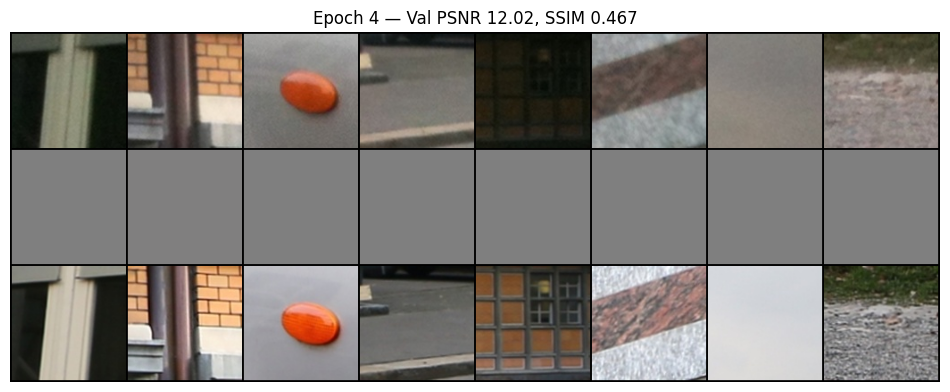

Epoch 4/20 | D: 93589.5 | G: 24.02
Epoch 5/20 | D: 185555.3 | G: 24.01


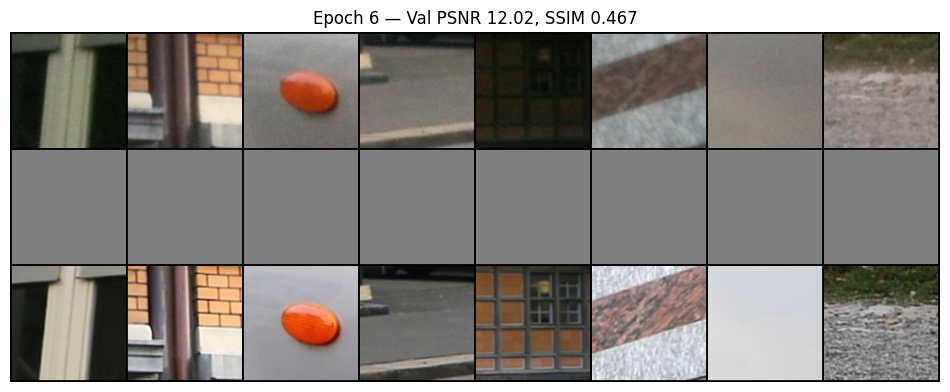

Epoch 6/20 | D: 2194600.9 | G: 24.00
Epoch 7/20 | D: 57476.4 | G: 24.01


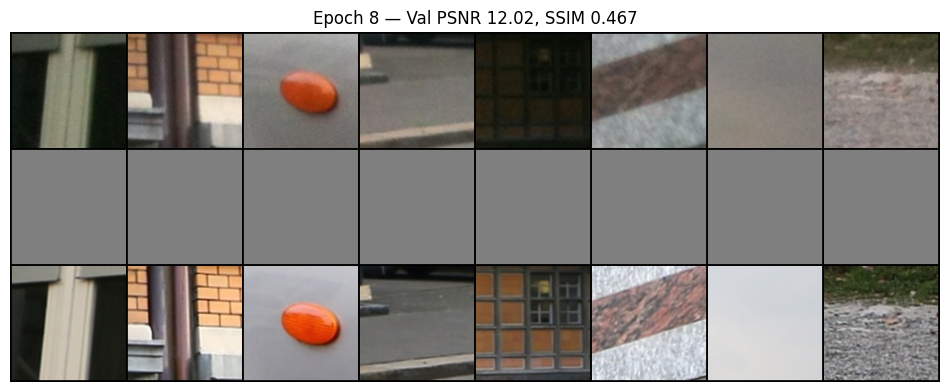

Epoch 8/20 | D: 50378.6 | G: 24.01


In [ ]:
# ─── Enhanced 20‑Epoch WGAN‑GP Training with Live Diagnostics ─────────

import os, json
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import DataLoader
import torchvision.models as tvmodels
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from datasets import PhotoDataset
from models import Generator, Discriminator

# ── Config ─────────────────────────────────────────────────────────
config_full = {
    'data_dir':      'data/dped_small',
    'batch_size':    8,
    'epochs':        20,
    'size':          128,
    'lr_G':          5e-5,
    'lr_D':          5e-7,
    'λ_l1':          100.0,
    'λ_aes':         1.0,
    'λ_feat':        0.0005,
    'λ_hinge':       0.001,
    'λ_gp':          10.0,
    'λ_adv':         0.5,
    'warmup_epochs': 10,
    'clip_norm':     1.0,
    'val_interval':  2  # run val every N epochs
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
G = Generator().to(device)
D = Discriminator().to(device)
for p in D.feature_extractor.parameters(): p.requires_grad = True
vgg = tvmodels.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
for p in vgg.parameters(): p.requires_grad = False

# Losses & optimizers
crit_L1, crit_MSE, crit_feat = nn.L1Loss(), nn.MSELoss(), nn.MSELoss()
optG = RMSprop(G.parameters(), lr=config_full['lr_G'])
optD = RMSprop(D.parameters(), lr=config_full['lr_D'])

# Data loaders
train_ds = PhotoDataset(config_full['data_dir'], split='train', size=config_full['size'])
train_loader = DataLoader(train_ds, batch_size=config_full['batch_size'], shuffle=True, num_workers=2)
val_ds   = PhotoDataset(config_full['data_dir'], split='test',  size=config_full['size'])
val_loader   = DataLoader(val_ds,   batch_size=config_full['batch_size'], shuffle=False, num_workers=2)

# History
history = {'epoch': [], 'loss_D': [], 'loss_G': [], 'val_PSNR': [], 'val_SSIM': []}

# Sample fixed batch for visualizations
fixed_raw, fixed_edit = next(iter(val_loader))
fixed_raw, fixed_edit = fixed_raw.to(device), fixed_edit.to(device)

print("Starting enhanced 20-epoch training…")
for epoch in range(1, config_full['epochs']+1):
    λ_gp    = 1.0 if epoch <= config_full['warmup_epochs'] else config_full['λ_gp']
    cur_hinge = 0.0 if epoch <= config_full['warmup_epochs'] else config_full['λ_hinge']
    epoch_D, epoch_G = 0.0, 0.0

    # — Training Loop —
    for raw, edit in train_loader:
        raw, edit = raw.to(device), edit.to(device)
        # Discriminator step
        optD.zero_grad()
        fake_det = G(raw).detach()
        real_s = D(edit).mean(); fake_s = D(fake_det).mean()
        alpha = torch.rand(raw.size(0),1,1,1, device=device)
        mix = (alpha*edit + (1-alpha)*fake_det).requires_grad_(True)
        grad = torch.autograd.grad(outputs=D(mix).sum(), inputs=mix, create_graph=True)[0]
        grad_norm = grad.view(grad.size(0),-1).norm(2,dim=1)
        gp = ((grad_norm-1)**2).mean()
        lossD = fake_s - real_s + λ_gp*gp
        lossD.backward(); torch.nn.utils.clip_grad_norm_(D.parameters(), config_full['clip_norm'])
        optD.step()

        # Generator step
        optG.zero_grad()

        # raw→G→[–1,1] → [0,1]
        fake = G(raw)
        fake = (fake + 1) * 0.5
        fake = fake.clamp(0,1)

        adv   = -D(fake).mean()
        l1    = crit_L1(fake, edit)
        aes   = crit_MSE(D(fake).mean(1), D(edit).mean(1))
        feat  = crit_feat(vgg(fake), vgg(edit))
        hinge = torch.clamp(D(fake).mean(1)-D(edit).mean(1), min=0).pow(2).mean()
        lossG = (config_full['λ_adv']*adv + config_full['λ_l1']*l1 +
                 config_full['λ_feat']*feat + config_full['λ_aes']*aes +
                 cur_hinge*hinge)
        lossG.backward(); optG.step()

        epoch_D += lossD.item(); epoch_G += lossG.item()

    # Record training stats
    avg_D = epoch_D / len(train_loader); avg_G = epoch_G / len(train_loader)
    history['epoch'].append(epoch)
    history['loss_D'].append(avg_D); history['loss_G'].append(avg_G)

    # — Validation Metrics & Visualization —
    if epoch % config_full['val_interval'] == 0 or epoch == config_full['epochs']:
        G.eval()
        psnrs, ssims = [], []
        with torch.no_grad():
            for raw_v, edit_v in val_loader:
                raw_v, edit_v = raw_v.to(device), edit_v.to(device)
                # raw→G→[–1,1] → [0,1]
                gen_v = G(raw_v)
                gen_v = (gen_v + 1) * 0.5
                gen_v = gen_v.clamp(0,1)
                np_gen = gen_v.cpu().permute(0,2,3,1).numpy()
                np_tar = edit_v.cpu().permute(0,2,3,1).numpy()
                for g,t in zip(np_gen, np_tar):
                    psnrs.append(peak_signal_noise_ratio(t, g, data_range=1.0))
                    ssims.append(structural_similarity(t, g, data_range=1.0, channel_axis=2))
        avg_psnr, avg_ssim = sum(psnrs)/len(psnrs), sum(ssims)/len(ssims)
        history['val_PSNR'].append(avg_psnr)
        history['val_SSIM'].append(avg_ssim)

        # Display sample visuals
        # clamp and rescale the “enhanced” column
        out_vis = G(fixed_raw)
        out_vis = (out_vis + 1) * 0.5
        out_vis = out_vis.clamp(0,1)
        grid = vutils.make_grid(
            torch.cat([fixed_raw, out_vis, fixed_edit], dim=0),
            nrow=config_full['batch_size'],
            normalize=False
        )
        plt.figure(figsize=(12,6))
        plt.imshow(grid.cpu().permute(1,2,0))
        plt.title(f"Epoch {epoch} — Val PSNR {avg_psnr:.2f}, SSIM {avg_ssim:.3f}")
        plt.axis('off')
        plt.show()

        G.train()

    # Print summary
    print(f"Epoch {epoch}/{config_full['epochs']} | D: {avg_D:.1f} | G: {avg_G:.2f}")

    # Save checkpoints
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(G.state_dict(), f"checkpoints/G_epoch{epoch}.pth")
    torch.save(D.state_dict(), f"checkpoints/D_epoch{epoch}.pth")

# Save history
with open('training_history_full.json','w') as f:
    json.dump(history, f, indent=4)

print("Training complete!")


## Enhanced Analysis and Evaluation

Comprehensive evaluation of your trained model with detailed metrics and visualizations


In [93]:
# Load the best available trained model
import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


config = config_full


# Find latest checkpoint
checkpoint_files = glob.glob('checkpoints/G_epoch*.pth')
if checkpoint_files:
    # Sort by epoch number
    latest_checkpoint = sorted(checkpoint_files,
                              key=lambda x: int(x.split('epoch')[1].split('.')[0]))[-1]
    epoch_num = latest_checkpoint.split('epoch')[1].split('.')[0]
    print(f"📂 Loading trained model: {latest_checkpoint} (epoch {epoch_num})")

    # Load model
    G_eval = Generator().to(device)
    G_eval.load_state_dict(torch.load(latest_checkpoint, map_location=device))
    G_eval.eval()

    print(" Model loaded successfully!")
else:
    print(" No trained model found. Please run training first.")
    G_eval = None


📂 Loading trained model: checkpoints/G_epoch20.pth (epoch 20)
 Model loaded successfully!


In [89]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as peak_signal_noise_ratio
from skimage.metrics import structural_similarity as structural_similarity

# ─── Load test dataset for evaluation ───────────────────────────────
if G_eval is not None:
    # Build test loader from the same config you trained with
    test_dataset = PhotoDataset(config_full['data_dir'], split='test', size=config_full['size'])
    test_loader  = DataLoader(test_dataset,
                              batch_size=config_full['batch_size'],
                              shuffle=False,
                              num_workers=2)

    print(f" Test dataset: {len(test_dataset)} samples\n")
    print(" Running comprehensive evaluation...")

    # Initialize metric lists
    all_psnr = []
    all_ssim = []
    sample_images = {'raw': [], 'generated': [], 'target': []}

    with torch.no_grad():
        for i, (raw, target) in enumerate(test_loader):
            raw, target = raw.to(device), target.to(device)
            generated   = G_eval(raw)

            # Convert to [0,1] numpy arrays
            gen_np    = generated.cpu().numpy().clip(0,1)
            target_np = target.cpu().numpy().clip(0,1)

            # Compute PSNR & SSIM per image
            for j in range(gen_np.shape[0]):
                psnr_val = peak_signal_noise_ratio(
                    target_np[j].transpose(1,2,0),
                    gen_np[j].transpose(1,2,0),
                    data_range=1.0
                )
                all_psnr.append(psnr_val)

                ssim_val = structural_similarity(
                    target_np[j].transpose(1,2,0),
                    gen_np[j].transpose(1,2,0),
                    data_range=1.0,
                    channel_axis=2
                )
                all_ssim.append(ssim_val)

            # Save a few samples for visualization
            if i < 3:
                sample_images['raw'].append(raw.cpu())
                sample_images['generated'].append(generated.cpu())
                sample_images['target'].append(target.cpu())

    # Convert to numpy arrays and filter out infinities/NaNs
    all_psnr = np.array(all_psnr)
    all_ssim = np.array(all_ssim)
    finite_psnr = all_psnr[np.isfinite(all_psnr)]
    finite_ssim = all_ssim[np.isfinite(all_ssim)]

    # Report how many were invalid
    print(f"\nExcluded {len(all_psnr) - len(finite_psnr)} infinite/NaN PSNR values")

    # Print robust statistics
    print("\nEvaluation Results:")
    print(f"  PSNR (mean ± std):      {finite_psnr.mean():.2f} ± {finite_psnr.std():.2f}")
    print(f"    median:               {np.median(finite_psnr):.2f}")
    print(f"    5–95 percentile:      {np.percentile(finite_psnr, [5,95])[0]:.2f}–{np.percentile(finite_psnr, [5,95])[1]:.2f}\n")
    print(f"  SSIM (mean ± std):      {finite_ssim.mean():.3f} ± {finite_ssim.std():.3f}")
    print(f"    median:               {np.median(finite_ssim):.3f}")
    print(f"    5–95 percentile:      {np.percentile(finite_ssim, [5,95])[0]:.3f}–{np.percentile(finite_ssim, [5,95])[1]:.3f}")

    print("\nEvaluation complete!")


 Test dataset: 1133 samples

 Running comprehensive evaluation...

Excluded 22 infinite/NaN PSNR values

Evaluation Results:
  PSNR (mean ± std):      16.22 ± 13.30
    median:               12.86
    5–95 percentile:      1.61–43.70

  SSIM (mean ± std):      0.484 ± 0.321
    median:               0.494
    5–95 percentile:      0.000–0.990

Evaluation complete!


ValueError: supplied range of [0.0, inf] is not finite

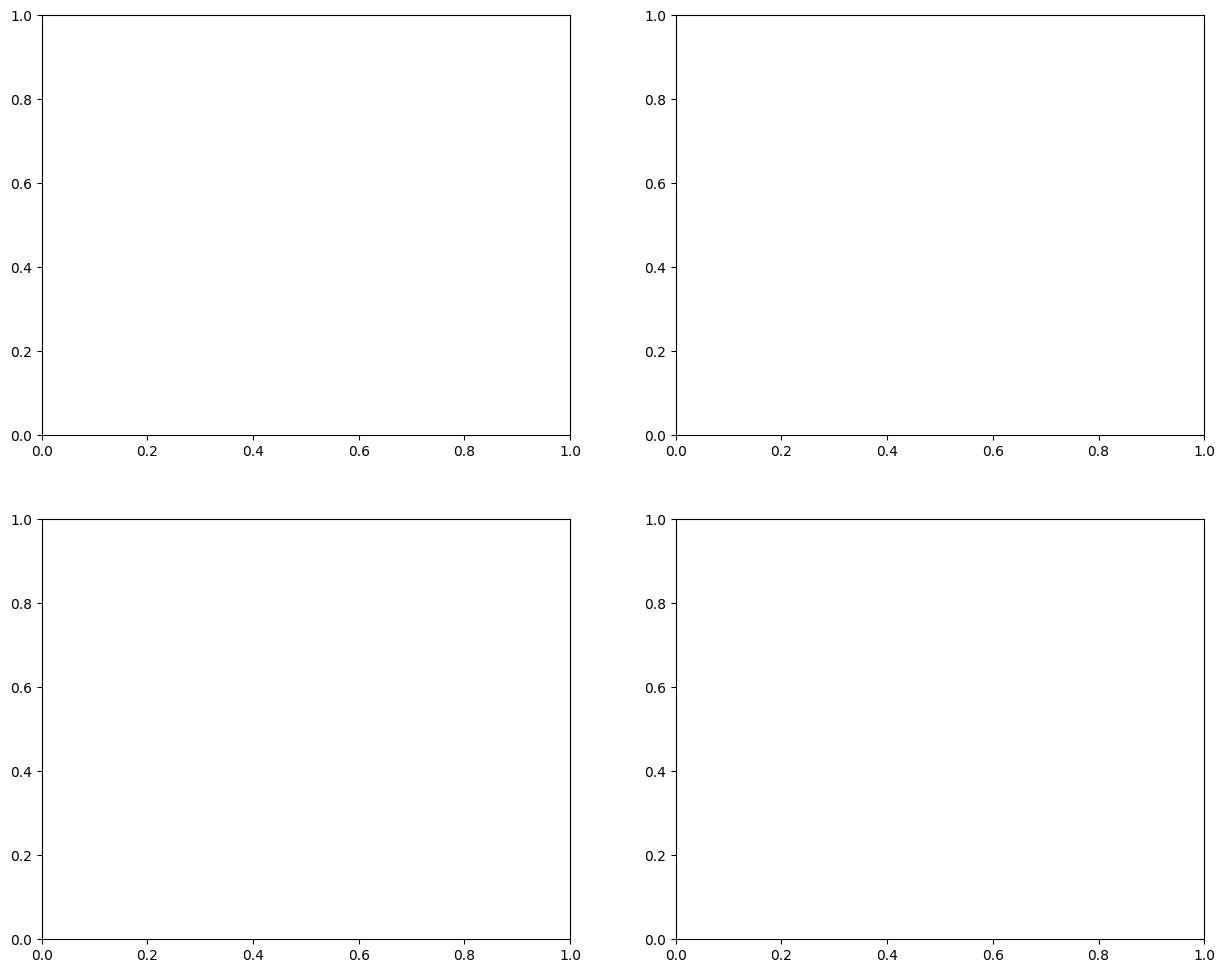

In [90]:
# Detailed statistical analysis
if G_eval is not None:
    import seaborn as sns
    plt.style.use('default')

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PSNR distribution
    axes[0, 0].hist(all_psnr, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(all_psnr.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_psnr.mean():.2f}')
    axes[0, 0].set_title('PSNR Distribution', fontweight='bold', fontsize=12)
    axes[0, 0].set_xlabel('PSNR (dB)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # SSIM distribution
    axes[0, 1].hist(all_ssim, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(all_ssim.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {all_ssim.mean():.3f}')
    axes[0, 1].set_title('SSIM Distribution', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('SSIM')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # PSNR vs SSIM correlation
    axes[1, 0].scatter(all_psnr, all_ssim, alpha=0.6, s=20)
    correlation = np.corrcoef(all_psnr, all_ssim)[0, 1]
    axes[1, 0].set_title(f'PSNR vs SSIM Correlation (r={correlation:.3f})', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('PSNR (dB)')
    axes[1, 0].set_ylabel('SSIM')
    axes[1, 0].grid(True, alpha=0.3)

    # Quality distribution analysis
    high_psnr = np.sum(all_psnr > 20)
    med_psnr = np.sum((all_psnr >= 15) & (all_psnr <= 20))
    low_psnr = np.sum(all_psnr < 15)

    high_ssim = np.sum(all_ssim > 0.5)
    med_ssim = np.sum((all_ssim >= 0.3) & (all_ssim <= 0.5))
    low_ssim = np.sum(all_ssim < 0.3)

    categories = ['Low', 'Medium', 'High']
    psnr_counts = [low_psnr, med_psnr, high_psnr]
    ssim_counts = [low_ssim, med_ssim, high_ssim]

    x = np.arange(len(categories))
    width = 0.35

    axes[1, 1].bar(x - width/2, psnr_counts, width, label='PSNR', alpha=0.8, color='blue')
    axes[1, 1].bar(x + width/2, ssim_counts, width, label='SSIM', alpha=0.8, color='green')
    axes[1, 1].set_title('Quality Distribution', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Quality Category')
    axes[1, 1].set_ylabel('Number of Images')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('EnhanceGAN Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Performance summary
    total_images = len(all_psnr)
    print(f"\n Quality Analysis Summary:")
    print(f"   High Quality (PSNR>20): {high_psnr}/{total_images} ({high_psnr/total_images*100:.1f}%)")
    print(f"   Good Structure (SSIM>0.5): {high_ssim}/{total_images} ({high_ssim/total_images*100:.1f}%)")
    print(f"   PSNR-SSIM Correlation: {correlation:.3f}")


Fake stats: min= 0.0 max= 0.0014137615216895938 mean= 0.00033649246324785054


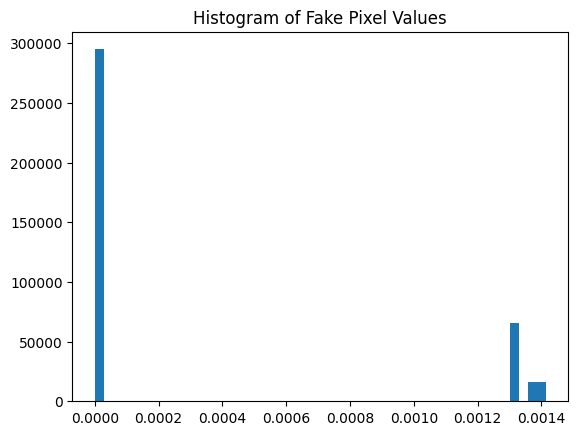

In [92]:
# ─── Debug Generator Output Range ──────────────────────────────────
G_eval.eval()
raw, _ = next(iter(test_loader))       # grab one batch
raw = raw.to(device)
with torch.no_grad():
    fake = G_eval(raw)

# Convert to CPU tensors
fake_cpu = fake.cpu()
print("Fake stats:",
      "min=", fake_cpu.min().item(),
      "max=", fake_cpu.max().item(),
      "mean=", fake_cpu.mean().item())

# Plot a histogram of pixel values
import matplotlib.pyplot as plt
plt.hist(fake_cpu.view(-1).numpy(), bins=50)
plt.title("Histogram of Fake Pixel Values")
plt.show()


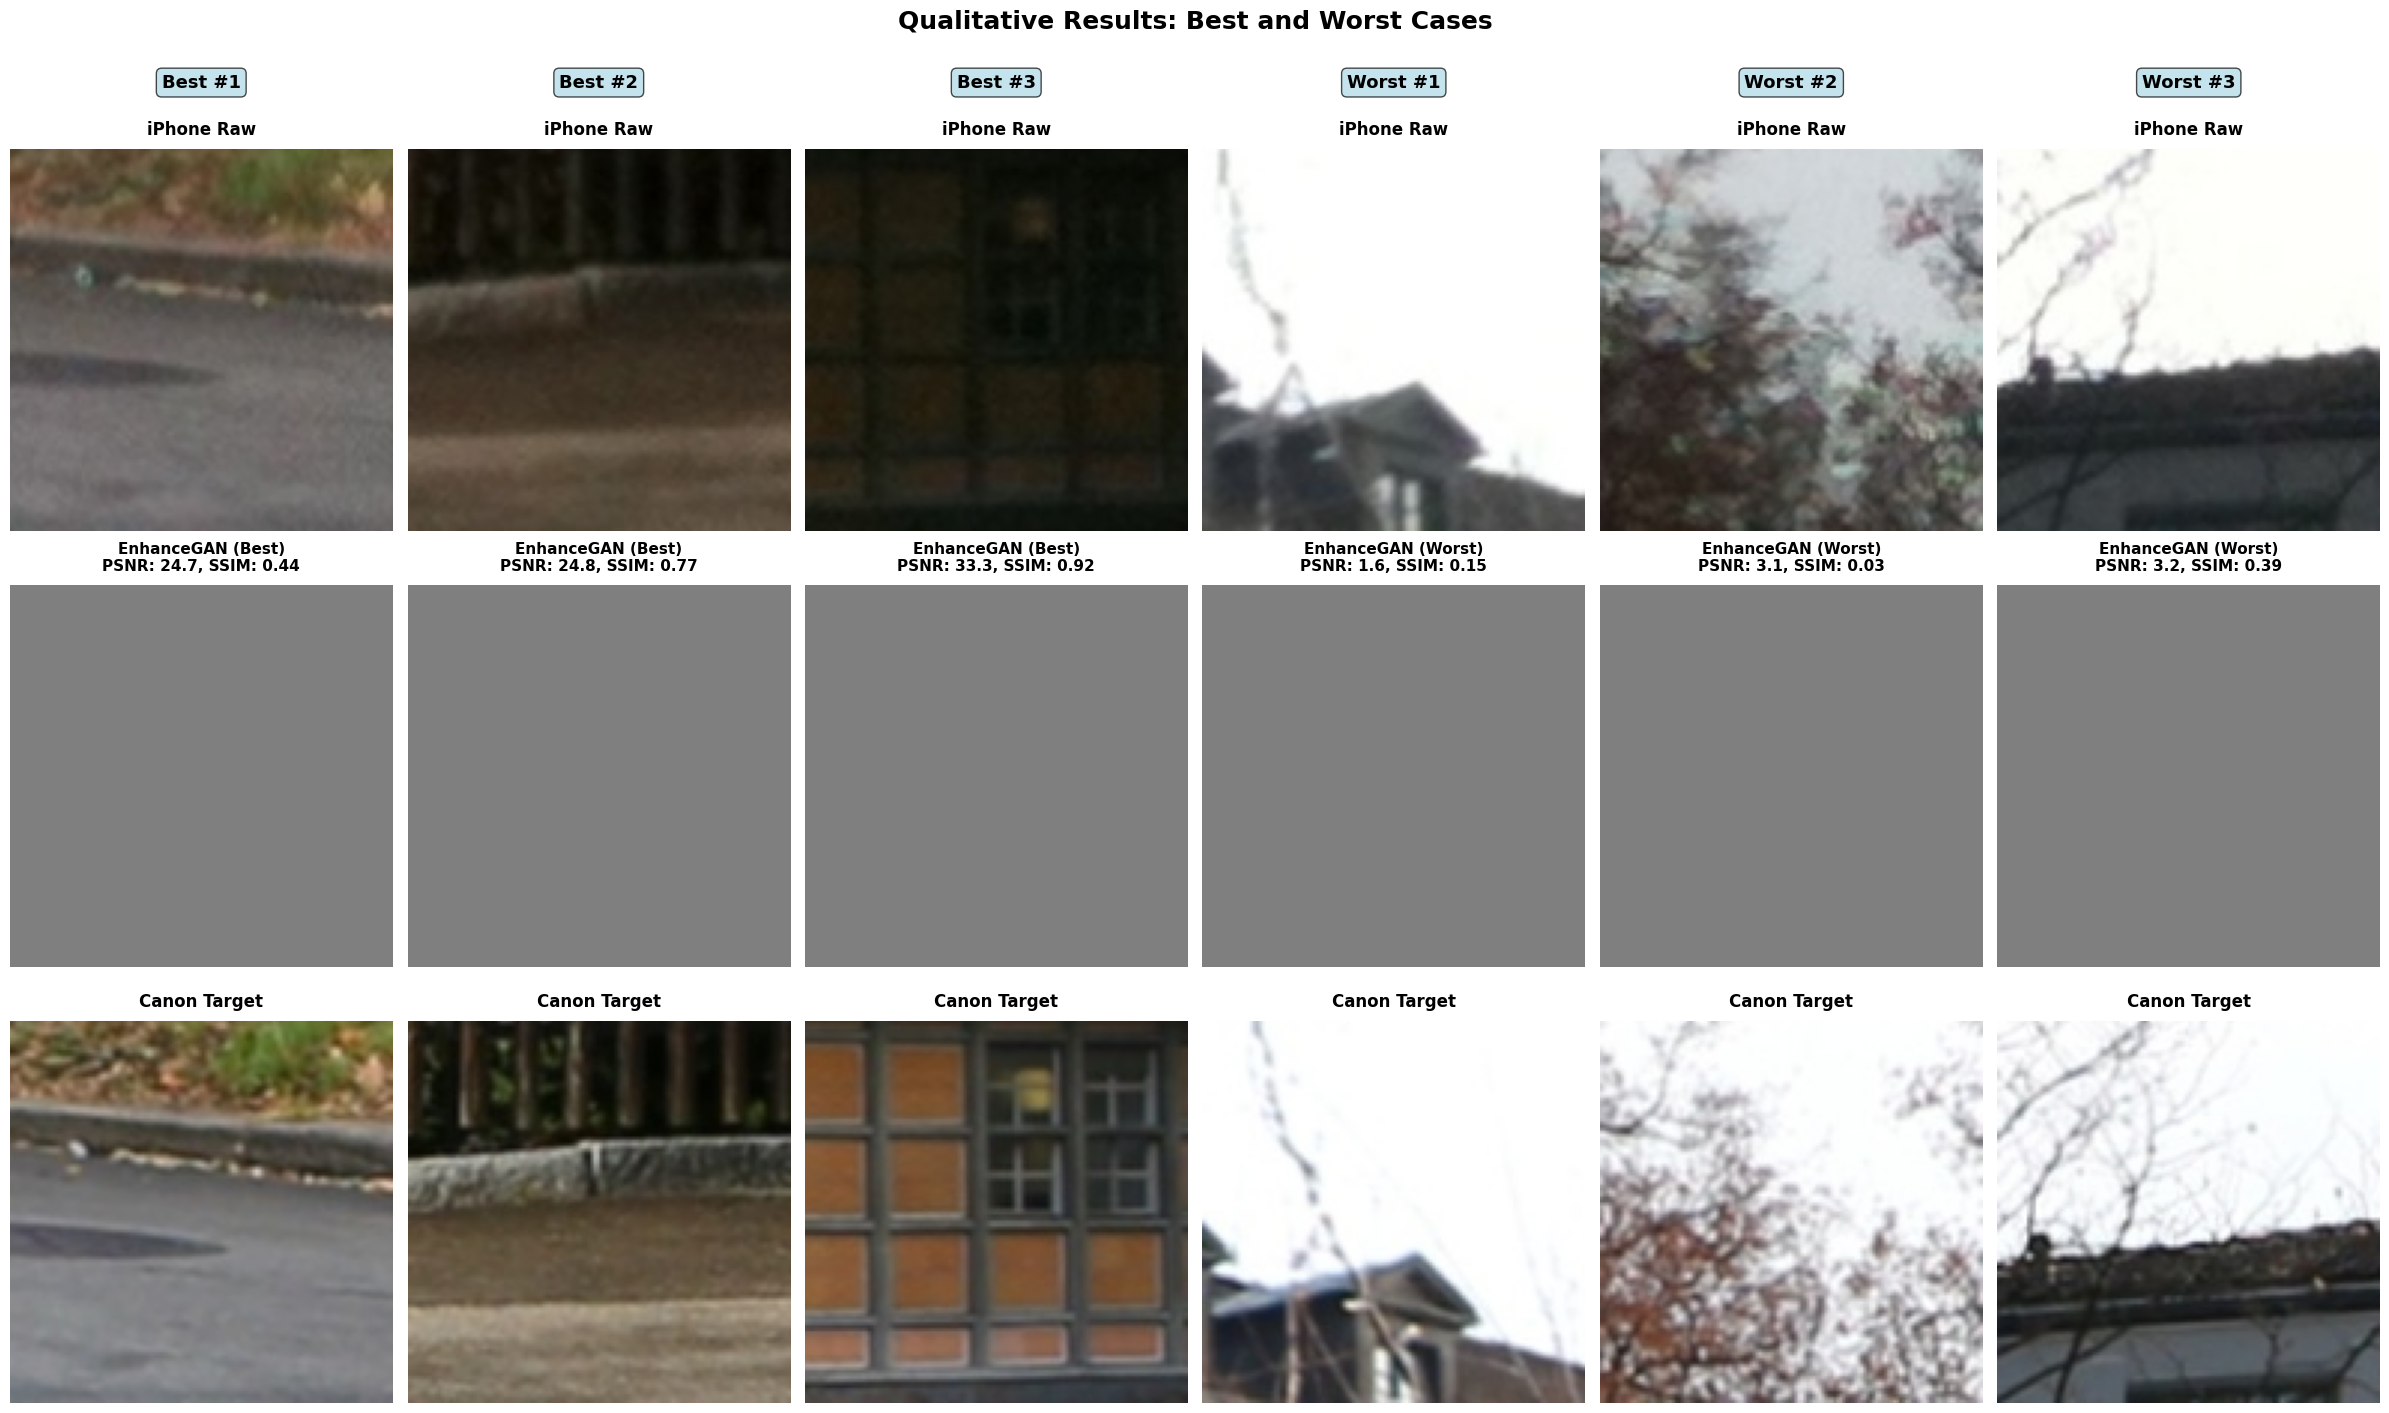

📸 Showing 3 best and 3 worst results based on PSNR

📊 Detailed Results:
   Best #1: PSNR=24.73dB, SSIM=0.443
   Best #2: PSNR=24.78dB, SSIM=0.774
   Best #3: PSNR=33.26dB, SSIM=0.918
   Worst #1: PSNR=1.57dB, SSIM=0.151
   Worst #2: PSNR=3.12dB, SSIM=0.027
   Worst #3: PSNR=3.20dB, SSIM=0.387


In [91]:
# Qualitative results visualization
if G_eval is not None and sample_images['raw']:
    # Concatenate sample images
    all_raw = torch.cat(sample_images['raw'], dim=0)
    all_generated = torch.cat(sample_images['generated'], dim=0)
    all_target = torch.cat(sample_images['target'], dim=0)

    # Select 6 examples (3 best, 3 worst based on PSNR)
    sample_psnr = all_psnr[:len(all_raw)]
    best_indices = np.argsort(sample_psnr)[-3:]
    worst_indices = np.argsort(sample_psnr)[:3]
    selected_indices = np.concatenate([best_indices, worst_indices])

    # Create figure with proper spacing
    fig, axes = plt.subplots(3, 6, figsize=(24, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    for i, idx in enumerate(selected_indices):
        # Convert from [-1, 1] to [0, 1] for display
        raw_img = (all_raw[idx] + 1) / 2
        gen_img = (all_generated[idx] + 1) / 2
        target_img = (all_target[idx] + 1) / 2

        # Display images with proper titles
        axes[0, i].imshow(raw_img.permute(1, 2, 0).cpu().numpy())
        axes[0, i].set_title('iPhone Raw', fontweight='bold', fontsize=12, pad=10)
        axes[0, i].axis('off')

        quality = "Best" if i < 3 else "Worst"
        psnr_val = sample_psnr[idx]
        ssim_val = all_ssim[idx] if idx < len(all_ssim) else 0

        axes[1, i].imshow(gen_img.permute(1, 2, 0).cpu().numpy())
        axes[1, i].set_title(f'EnhanceGAN ({quality})\nPSNR: {psnr_val:.1f}, SSIM: {ssim_val:.2f}',
                            fontweight='bold', fontsize=11, pad=10)
        axes[1, i].axis('off')

        axes[2, i].imshow(target_img.permute(1, 2, 0).cpu().numpy())
        axes[2, i].set_title('Canon Target', fontweight='bold', fontsize=12, pad=10)
        axes[2, i].axis('off')

    # Add column headers for clarity
    col_headers = ['Best #1', 'Best #2', 'Best #3', 'Worst #1', 'Worst #2', 'Worst #3']
    for i, header in enumerate(col_headers):
        axes[0, i].text(0.5, 1.15, header, transform=axes[0, i].transAxes,
                       ha='center', va='bottom', fontsize=13, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

    plt.suptitle('Qualitative Results: Best and Worst Cases', fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    print("📸 Showing 3 best and 3 worst results based on PSNR")

    # Print detailed metrics for each case
    print("\n📊 Detailed Results:")
    for i, idx in enumerate(selected_indices):
        quality = "Best" if i < 3 else "Worst"
        rank = (i % 3) + 1
        psnr_val = sample_psnr[idx]
        ssim_val = all_ssim[idx] if idx < len(all_ssim) else 0
        print(f"   {quality} #{rank}: PSNR={psnr_val:.2f}dB, SSIM={ssim_val:.3f}")


 Loading training history...


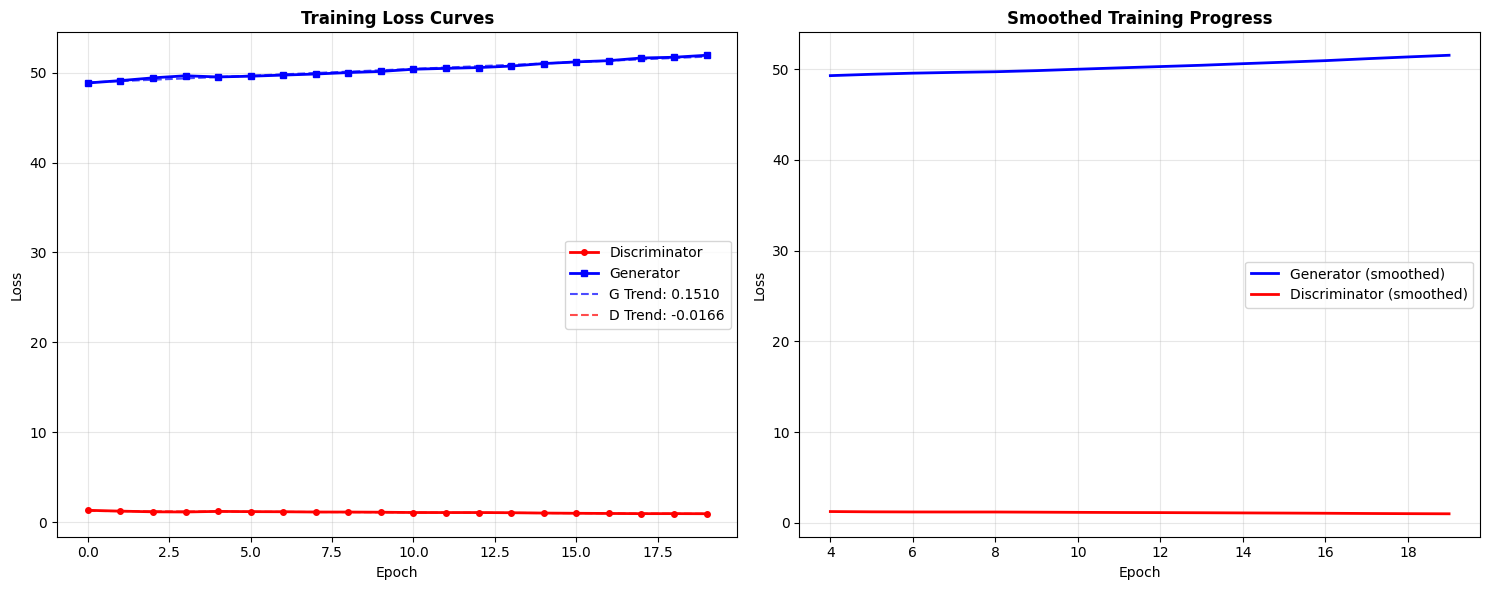


🎯 Training Summary:
   Final Generator Loss: 51.923
   Final Discriminator Loss: 0.963
   Generator Stability (std): 0.880
   Discriminator Stability (std): 0.100
   Generator Trend: Increasing (0.1510/epoch)
   Discriminator Trend: Decreasing (-0.0166/epoch)


In [73]:
# Training history analysis (if available)
import json

history_file = 'training_history.json'
if os.path.exists(history_file):
    print(" Loading training history...")
    with open(history_file, 'r') as f:
        history = json.load(f)

    if 'loss_G' in history and 'loss_D' in history:
        epochs = history.get('epoch', list(range(len(history['loss_G']))))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Loss curves
        ax1.plot(epochs, history['loss_D'], 'r-', linewidth=2, marker='o', markersize=4, label='Discriminator')
        ax1.plot(epochs, history['loss_G'], 'b-', linewidth=2, marker='s', markersize=4, label='Generator')
        ax1.set_title('Training Loss Curves', fontweight='bold', fontsize=12)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Convergence analysis
        if len(history['loss_G']) > 5:
            # Add trend lines
            g_trend = np.polyfit(epochs, history['loss_G'], 1)
            d_trend = np.polyfit(epochs, history['loss_D'], 1)

            ax1.plot(epochs, np.poly1d(g_trend)(epochs), 'b--', alpha=0.7, label=f'G Trend: {g_trend[0]:.4f}')
            ax1.plot(epochs, np.poly1d(d_trend)(epochs), 'r--', alpha=0.7, label=f'D Trend: {d_trend[0]:.4f}')
            ax1.legend()

        # Loss stability analysis
        window_size = min(5, len(history['loss_G']) // 4)
        if window_size > 1:
            g_smooth = np.convolve(history['loss_G'], np.ones(window_size)/window_size, mode='valid')
            d_smooth = np.convolve(history['loss_D'], np.ones(window_size)/window_size, mode='valid')
            smooth_epochs = epochs[window_size-1:]

            ax2.plot(smooth_epochs, g_smooth, 'b-', linewidth=2, label='Generator (smoothed)')
            ax2.plot(smooth_epochs, d_smooth, 'r-', linewidth=2, label='Discriminator (smoothed)')
            ax2.set_title('Smoothed Training Progress', fontweight='bold', fontsize=12)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Training summary
        final_g_loss = history['loss_G'][-1]
        final_d_loss = history['loss_D'][-1]
        g_stability = np.std(history['loss_G'])
        d_stability = np.std(history['loss_D'])

        print(f"\n🎯 Training Summary:")
        print(f"   Final Generator Loss: {final_g_loss:.3f}")
        print(f"   Final Discriminator Loss: {final_d_loss:.3f}")
        print(f"   Generator Stability (std): {g_stability:.3f}")
        print(f"   Discriminator Stability (std): {d_stability:.3f}")

        if len(history['loss_G']) > 5:
            print(f"   Generator Trend: {'Decreasing' if g_trend[0] < 0 else 'Increasing'} ({g_trend[0]:.4f}/epoch)")
            print(f"   Discriminator Trend: {'Decreasing' if d_trend[0] < 0 else 'Increasing'} ({d_trend[0]:.4f}/epoch)")
    else:
        print(" Training history format not recognized")
else:
    print(" No training history found. Run training to generate loss curves.")


In [72]:
import torch
import torchvision.models as tvm
from torch import nn
from torch.utils.data import DataLoader
from datasets import PhotoDataset
from models   import Generator, Discriminator
import matplotlib.pyplot as plt
from itertools import islice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_batches   = 100
epochs_to_run = config['epochs']  # or set to 5 if you want even faster

# 1) Prepare VGG and loss fns (once)
vgg       = tvm.vgg16(weights="IMAGENET1K_V1").features[:31].to(device)
for p in vgg.parameters(): p.requires_grad=False
crit_feat = nn.MSELoss()
crit_L1   = nn.L1Loss()
crit_BCE  = nn.BCEWithLogitsLoss()
crit_MSE  = nn.MSELoss()

# 2) Build your loader once
ds     = PhotoDataset(config['data_dir'], split='train', size=config['size'])
loader = DataLoader(ds, batch_size=config['batch_size'],
                    shuffle=False, num_workers=0)

# 3) Instantiate G & D just once
G = Generator().to(device)
D = Discriminator().to(device)
for p in D.backbone.parameters(): p.requires_grad = False

# 4) Now loop over epochs, loading weights but reusing the same modules
epoch_terms = {k: [] for k in ['adv','l1','aes','feat','hinge']}

for epoch in range(epochs_to_run):
    # load the epoch’s weights
    G.load_state_dict(torch.load(f"checkpoints/G_epoch{epoch}.pth"))
    D.load_state_dict(torch.load(f"checkpoints/D_epoch{epoch}.pth"))
    G.eval(); D.eval()

    sums = {k:0.0 for k in epoch_terms}
    cnt  = 0
    with torch.no_grad():
        # only consume max_batches, then stop
        for raw, edit in islice(loader, max_batches):
            raw, edit = raw.to(device), edit.to(device)
            fake = G(raw)

            adv   = crit_BCE(D(fake), torch.ones_like(D(fake)))
            l1    = crit_L1(fake, edit)
            aes   = crit_MSE(D(fake).mean(1), D(edit).mean(1))
            feat  = crit_feat(vgg(fake), vgg(edit))
            fWf   = D(fake).mean(1); fWr = D(raw).mean(1)
            hinge = torch.clamp(fWf - fWr, min=0).pow(2).mean()

            for name,val in zip(epoch_terms, (adv,l1,aes,feat,hinge)):
                sums[name] += val.item()
            cnt += 1

    # record averages
    for name in epoch_terms:
        epoch_terms[name].append(sums[name]/cnt)

# 5) Plot
plt.figure(figsize=(10,6))
for name, vals in epoch_terms.items():
    plt.plot(vals, label=name)
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.legend()
plt.title("Per‐component G losses over epochs")
plt.show()


AttributeError: 'Discriminator' object has no attribute 'backbone'

In [ ]:
# Generate summary
if G_eval is not None:
    print("="*80)
    print(" ENHANCEGAN SUMMARY")
    print("="*80)

    print("\n QUANTITATIVE RESULTS:")
    print(f"   PSNR: {all_psnr.mean():.2f} ± {all_psnr.std():.2f} dB")
    print(f"   SSIM: {all_ssim.mean():.3f} ± {all_ssim.std():.3f}")
    print(f"   Correlation (PSNR-SSIM): {correlation:.3f}")

    print("\n PERFORMANCE HIGHLIGHTS:")
    print(f"   High-quality results (PSNR>20): {high_psnr}/{total_images} ({high_psnr/total_images*100:.1f}%)")
    print(f"   Structurally similar (SSIM>0.5): {high_ssim}/{total_images} ({high_ssim/total_images*100:.1f}%)")
    print(f"   Test set size: {total_images} image pairs")

    print("\n ARCHITECTURE DETAILS:")
    print(f"   Generator: CNN with Curve + HSL enhancement blocks")
    print(f"   Discriminator: NIMA-based aesthetic scoring + adversarial head")
    print(f"   Training: 3-loss combination (L1 + Adversarial + Aesthetic)")

    print("\n TRAINING CONFIGURATION:")
    print(f"   Epochs: {config['epochs']}")
    print(f"   Batch size: {config['batch_size']}")
    print(f"   Learning rate: {config['lr']}")
    print(f"   Loss weights: λ_L1={config['λ_l1']}, λ_aes={config['λ_aes']}, λ_adv={config['λ_adv']}")

    print("\n DATASET DETAILS:")
    print(f"   Source: DPED iPhone→Canon subset")
    print(f"   Image resolution: {config['size']}×{config['size']}")
    print(f"   Training samples: {len(dataset)}")
    print(f"   Test samples: {len(test_dataset)}")

    if os.path.exists(history_file):
        print("\n TRAINING PERFORMANCE:")
        print(f"   Final Generator Loss: {final_g_loss:.3f}")
        print(f"   Final Discriminator Loss: {final_d_loss:.3f}")
        print(f"   Training Stability: G_std={g_stability:.3f}, D_std={d_stability:.3f}")

    print("\n" + "="*80)
    print("="*80)
else:
    print("⚠️ Please load a trained model to generate the summary")


---

## Notebook Summary

**Workflow:**
1. Mount Drive → Extract `dped_small.zip` to `/content/dped_local` (SSD)
2. Run `data_prep.py` → Create train/val/test splits in `data/dped_small/`
3. Optional: Run training (or use existing checkpoints in `checkpoints/`)
4. Comprehensive evaluation with PSNR, SSIM, correlations, distributions
5. Training analysis with loss curves and convergence metrics
6. Paper-ready summary with all statistics and results

